<a href="https://colab.research.google.com/github/ktaran-jeet/deepVision-ImageClassification/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AlexNet:

Highlights of the architecture:

* Use Relu instead of Tanh to add non-linearity. It accelerates the speed by 6 times at the same accuracy.

* Use dropout instead of regularisation to deal with overfitting. However the training time is doubled with the dropout rate of 0.5.

* Overlap pooling to reduce the size of network. It reduces the top-1 and top-5 error rates by 0.4% and 0.3%, repectively.








In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

It contains 5 convolutional layers and 3 fully connected layers. Relu is applied after very convolutional and fully connected layer. Dropout is applied before the first and the second fully connected year.

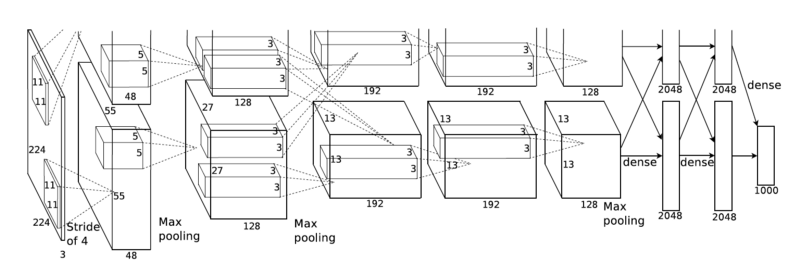

Data Loading and preprocessing:

In [3]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CIFAR10('data', train=True, transform=transform, download=True)
test_data = CIFAR10('data', train=False, transform=transform, download=True)

print("Training data samples:",len(train_data))
print("Testing data samples:",len(test_data))

Files already downloaded and verified
Files already downloaded and verified
Training data samples: 50000
Testing data samples: 10000


In [4]:
num_classes = 10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


#Separate a validation set out of training set:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=20, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=20, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=20)

Model implementation:

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):

  def __init__(self):
    super(AlexNet, self).__init__()
    self.convlayers = nn.Sequential(
        nn.Conv2d(3, 64, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.BatchNorm2d(256),
        nn.Conv2d(256, 512, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.BatchNorm2d(512),
    )
    self.fclayers = nn.Sequential(
        nn.Linear(2*2*512, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.25),
        nn.BatchNorm1d(128),
        nn.Linear(128, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.25),
        nn.BatchNorm1d(256),
        nn.Linear(256, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.25),
        nn.BatchNorm1d(512),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.25),
        nn.BatchNorm1d(1024),
        nn.Linear(1024,10),
    )


  def forward(self,x):
    x = self.convlayers(x)
    x = x.view(-1, 2*2*512)
    return self.fclayers(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = AlexNet()
model = model.to(device=device)
print(model)

Using device: cuda
AlexNet(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
   

Model Training:

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
num_epochs=50

total_train_loss = []
total_valid_loss = []
valid_loss_min = np.Inf

for epoch in range(num_epochs):
  train_loss = 0.0
  valid_loss = 0.0

  model.train()

  for data, target in train_loader:
    data = data.to(device=device)
    target = target.to(device=device)

    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()*data.size(0)

  model.eval()
  for data, target in valid_loader:
    data = data.to(device=device)
    target = target.to(device=device)

    output = model(data)
    loss = criterion(output, target)
    valid_loss += loss.item()*data.size(0)


  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)

  total_train_loss.append(train_loss)
  total_valid_loss.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))


  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model_cifar.pt')
      valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 1.091460 	Validation Loss: 0.214251
Validation loss decreased (inf --> 0.214251).  Saving model ...
Epoch: 1 	Training Loss: 0.952066 	Validation Loss: 0.204702
Validation loss decreased (0.214251 --> 0.204702).  Saving model ...
Epoch: 2 	Training Loss: 0.852585 	Validation Loss: 0.177903
Validation loss decreased (0.204702 --> 0.177903).  Saving model ...
Epoch: 3 	Training Loss: 0.783029 	Validation Loss: 0.161283
Validation loss decreased (0.177903 --> 0.161283).  Saving model ...
Epoch: 4 	Training Loss: 0.732979 	Validation Loss: 0.150268
Validation loss decreased (0.161283 --> 0.150268).  Saving model ...
Epoch: 5 	Training Loss: 0.684286 	Validation Loss: 0.150813
Epoch: 6 	Training Loss: 0.643862 	Validation Loss: 0.138392
Validation loss decreased (0.150268 --> 0.138392).  Saving model ...
Epoch: 7 	Training Loss: 0.610906 	Validation Loss: 0.134573
Validation loss decreased (0.138392 --> 0.134573).  Saving model ...
Epoch: 8 	Training Loss: 0.569812 

Model Evaluation:

In [18]:
model.load_state_dict(torch.load('model_cifar.pt'))

test_loss=0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
  data = data.to(device=device)
  target = target.to(device=device)

  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)

  _, pred = torch.max(output, 1)

  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.cpu().numpy())

  for i in range(10):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

<ipython-input-18-dc84bf3094b9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_cifar.pt'))


Test Loss: 0.547124

Test Accuracy of airplane: 85% (440/516)
Test Accuracy of automobile: 89% (446/498)
Test Accuracy of  bird: 75% (369/492)
Test Accuracy of   cat: 68% (335/487)
Test Accuracy of  deer: 78% (404/517)
Test Accuracy of   dog: 71% (362/503)
Test Accuracy of  frog: 87% (449/516)
Test Accuracy of horse: 86% (426/491)
Test Accuracy of  ship: 88% (441/497)
Test Accuracy of truck: 89% (431/483)

Test Accuracy (Overall): 82% (4103/5000)


Plots:

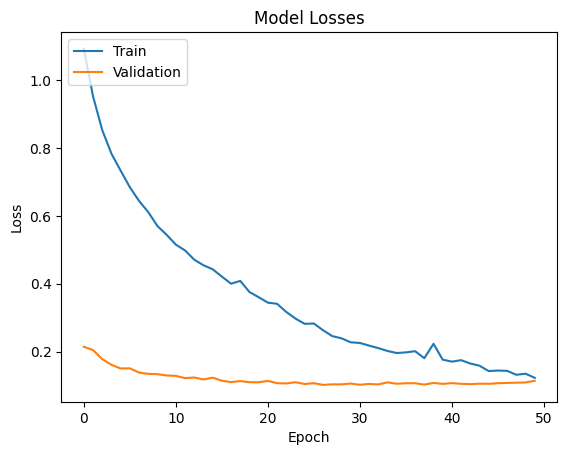

In [23]:
# Plot training & validation accuracy values
plt.plot(total_train_loss, label = 'Training Loss')
plt.plot(total_valid_loss, label = 'Validation Loss')
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()